<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S12/EVA_Session12_dog_image_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf eva
!git clone "https://github.com/siva-sankar-a/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 631, done.
remote: Total 631 (delta 0), reused 0 (delta 0), pack-reused 631
Receiving objects: 100% (631/631), 8.49 MiB | 25.95 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [0]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [0]:
df = pd.read_json('./eva/S12/eva_session12_dog_annotation.json').transpose()

In [0]:
root_dir = './eva/S12/dog_images'
df.reset_index(drop=True, inplace=True)

In [0]:
df['path'] = df['filename'].apply(lambda x: os.path.join(root_dir, x))

In [0]:
height = []
width = []
norm_bb_shapes = []
x = []
y = []
for idx, row in df.iterrows():
  img = cv2.imread(row['path'])
  h, w, c = img.shape
  height.append(h)
  width.append(w)

  norm_bb_shapes_for_region = []
  for region in row['regions']:
    bb_h, bb_w = region['shape_attributes']['height'], region['shape_attributes']['width']
    norm_bb_shapes_for_region.append((bb_h / h, bb_w / w))
    x.append(bb_w / w)
    y.append(bb_h / h)

  norm_bb_shapes.append(norm_bb_shapes_for_region)

In [0]:
df['height'] = height
df['width'] = width
df['norm_bb_shapes'] = norm_bb_shapes

In [13]:
df.head()

,filename,size,regions,file_attributes,path,height,width,norm_bb_shapes
0,ia_100000003.jpeg,1871,"[{'shape_attributes': {'name': 'rect', 'x': 2,...","{'caption': '', 'public_domain': 'no', 'image_...",./eva/S12/dog_images/ia_100000003.jpeg,100,100,"[(0.92, 0.94)]"
1,ia_100000004.jpeg,2290,"[{'shape_attributes': {'name': 'rect', 'x': 5,...","{'caption': '', 'public_domain': 'no', 'image_...",./eva/S12/dog_images/ia_100000004.jpeg,100,100,"[(0.86, 0.89)]"
2,ia_100000005.jpeg,2275,"[{'shape_attributes': {'name': 'rect', 'x': 4,...","{'caption': '', 'public_domain': 'no', 'image_...",./eva/S12/dog_images/ia_100000005.jpeg,100,100,"[(0.94, 0.94)]"
3,ia_100000006.jpeg,1589,"[{'shape_attributes': {'name': 'rect', 'x': 5,...","{'caption': '', 'public_domain': 'no', 'image_...",./eva/S12/dog_images/ia_100000006.jpeg,100,100,"[(0.94, 0.92)]"
4,ia_100000007.jpeg,2381,"[{'shape_attributes': {'name': 'rect', 'x': 2,...","{'caption': '', 'public_domain': 'no', 'image_...",./eva/S12/dog_images/ia_100000007.jpeg,100,100,"[(0.75, 0.87)]"


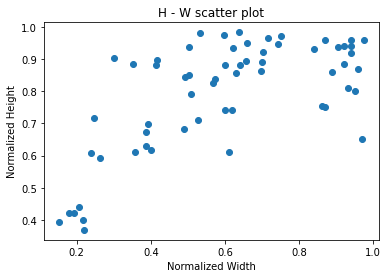

In [105]:
plt.scatter(x, y)
plt.title('H - W scatter plot')
plt.xlabel('Normalized Width')
plt.ylabel('Normalized Height')
plt.show()

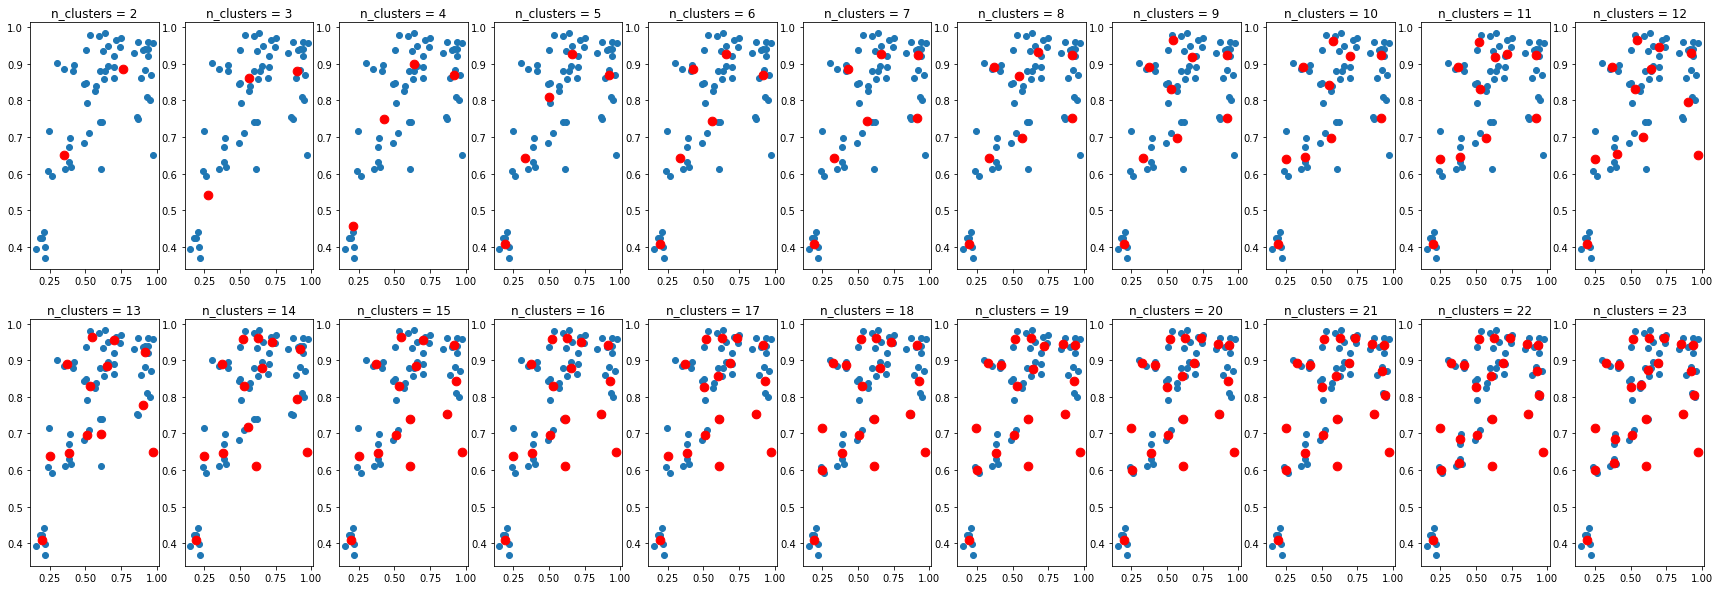

In [79]:
X = np.array([x, y])
X = X.transpose()

min_clusters = 2
max_clusters = 24

n_cluster_range = np.arange(min_clusters, max_clusters, 1)
cluster_centers = {}

for n_clusters in n_cluster_range:
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
  pred_y = kmeans.fit_predict(X)
  cluster_centers[n_clusters] = kmeans.cluster_centers_

rows = 2

fig = plt.figure(figsize=(30, 10))
for idx, n_clusters in enumerate(n_cluster_range):
  plt.subplot(rows, (max_clusters - min_clusters) // rows, idx + 1)
  plt.scatter(X[:,0], X[:,1])
  plt.scatter(cluster_centers[n_clusters][:, 0], cluster_centers[n_clusters][:, 1], s=75, c='red')
  plt.title(f'n_clusters = {n_clusters}')

plt.show()

In [0]:
def bb_iou(bb_1, bb_2):
  
  x_1, y_1 = bb_1
  x_2, y_2 = bb_2

  inter_area = min(x_1, x_2) * min(y_1, y_2)
  
  bb_1_area = x_1 * y_1
  bb_2_area = x_2 * y_2

  iou = inter_area / float(bb_1_area + bb_2_area - inter_area)
  return iou

In [0]:
# For all cluster sizes
mean_ious = {}
for n_cluster,  centers in cluster_centers.items():

  bb_max_ious = []

  # For all images
  for norm_bb_shape in df['norm_bb_shapes'].values:
    
    # For all bounding boxes in an image
    for bb in norm_bb_shape:
      
      max_iou = max([bb_iou(bb, center) for center in centers])
      bb_max_ious.append(max_iou)
  
  mean_ious[n_cluster] = np.mean(bb_max_ious)

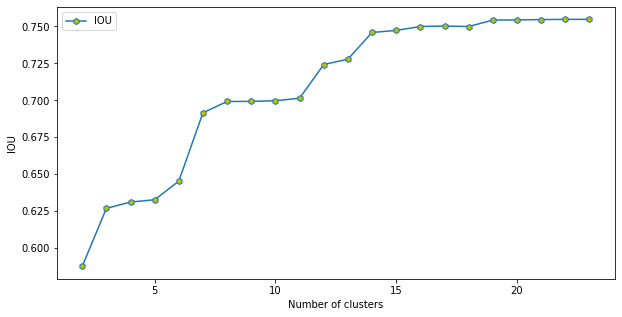

In [102]:
fig = plt.figure(figsize=(10, 5))
ax = pd.Series(mean_ious, name='IOU').plot(marker='h', markerfacecolor='y')
ax.legend()
ax.set_xlabel("Number of clusters")
ax.set_ylabel("IOU")
plt.show()

Selected number of clusters is **7** as IOU stagnates for higher values 